<div style="text-align: center; font-size: 25px;">
    Dynamic Factor Models : Does the Specification Matter ?
</div>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf
from scipy.stats import norm

plt.style.use(style='bmh')

Fonctions.

In [ ]:
def fred_transform(data: pd.DataFrame, transformations: dict[str, int]) -> pd.DataFrame:
    """ 
    Transforme les séries de données macro-économiques selon les recommandations fournies par McCracken et Ng (2016).

    Arguments
    ---------
    data : pd.DataFrame
        Tableau de données macro-économiques extraties de la base fred-md.
     transformations : dict[str, int]
        Dictionnaire ayant pour clé le nom de la série et pour valeur son code de transformation associé.

    Renvoie
    ---------
    pd.DataFrame :
        Tableau des séries stationnarisées.
    """
    # Création du DataFrame stockant les séries transformées
    result = pd.DataFrame()
    # Transformation des séries selon les codes fournis par McCracken et Ng (2016)
    for col in data.columns:
        # Récupération du code de transformation
        code = transformations[col]
        # Récupération de la série individuelle
        subset = data[col]

        # Application des transformées selon le code correspondant
        # --------------------------------------------------------
        if code == 1:
            temp = subset # Aucune transformation à appliquer
        elif code == 2:
            temp = subset.diff(periods=1) # Différence première
        elif code == 3: 
            temp = subset.diff(periods=1).diff(periods=1) # Différence seconde
        elif code == 4:
            temp = np.log(subset) # Transformée en log
        elif code == 5:
            temp = np.log(subset).diff(periods=1) # Différence première du log
        elif code == 6:
            temp = np.log(subset).diff(periods=1).diff(periods=1) # Différence seconde du log 
        elif code == 7:
            temp = subset.pct_change().diff(periods=1) # Différence première de la variation relative
        # --------------------------------------------------------

        # Aggrégation des séries transformées
        result = pd.concat([result, temp], axis=1)
    # Renvoi des séries transformées et abandonnées des NaN's
    return result.dropna(axis=0)

def remove_outliers(transformed_data: pd.DataFrame) -> pd.DataFrame:
    """ 
    Traite les séries transformées de la base fred-md de leurs outliers.
    Un point x est considéré comme outlier si abs(x - mediane) > 10 * gamme interquartile.

    Arguments
    ---------
    transformed_data : pd.DataFrame
        Tableau des données macro-économiques transformées de la base fred-md.

    Renvoie
    ---------
    pd.DataFrame :
        Tableau des séries transformées corrigées des outliers.
    """
    # Calcul de la médiane des séries
    medians = transformed_data.median(axis=0)
    # DataFrame contenant les médianes des séries en chaque point
    mdf =  transformed_data * 0 + medians
    # Calcul de la distance entre les observations et les médianes
    z = abs(transformed_data - mdf)
    # Calcul de la gamme interquartile des séries
    irq = transformed_data.quantile(q=.75) - transformed_data.quantile(q=.25)
    # DataFrame contenant les gammes interquartiles des séries en chaque point
    irqdf = transformed_data * 0 + irq
    # Détermination des outliers selon la régle fournie par McCracken et Ng (2016)
    outliers = z > 10 * irqdf
    # Abandon des observations considérées comme outliers
    mapping = transformed_data[outliers == False].dropna(axis=0)
    # Renvoi des séries traitées des outliers
    return mapping

In [ ]:
def pc(Y: np.ndarray, r: int) -> tuple:
    """ 
    Extrait les facteurs et les charges d'une série de données standardisée par analyse en composantes principales.

    Arguments
    ---------
    Y : np.ndarray
        Matrice (TxN) de données standardisées.
    r : int
        Nombre de facteurs à estimer.

    Renvoie
    ---------
    tuple :
        Matrice (Txr) des facteurs estimés, 
        Matrice (Nxr) des charges factorielles estimées,
        Vecteur (rx1) des r plus grandes valeurs propres.
    """
    # Calcul de la matrice de covariance de Y
    covmat = np.cov(Y, rowvar=False)
    # Calcul des valeurs et vecteurs propres
    eigvals, eigvecs = np.linalg.eig(covmat)
    # Récupération des indices des valeurs propres dans l'ordre décroissant
    idx = np.argsort(eigvals)[::-1]
    # Tri des valeurs propres dans l'ordre décroissant
    sorted_eigvals = eigvals[idx]
    # Tri des vecteurs propres selon leur valeur propre associée
    sorted_eigvecs = eigvecs[:, idx]
    # Récupération des r premiers vecteurs propres
    loadings = sorted_eigvecs[:, :r]
    # Estimation des facteurs par projection
    factors = Y @ loadings
    # Renvoi des facteurs, charges factorielles et r premières valeurs propres
    return factors, loadings, sorted_eigvals[:r]

def kalman_filter(Y: np.ndarray, r: int, f0: np.ndarray, 
                  p0: np.ndarray, lbda: np.ndarray, phi: np.ndarray, 
                  sigma_e: np.ndarray, sigma_u: np.ndarray=None) -> tuple:
    """ 
    Applique le filtre de Kalman pour un modèle DFM dans lequel la variable d'etat évolue selon un VAR(p=1).

    Arguments
    ---------
    Y : np.ndarray
        Matrice (TxN) de données standardisées.
    r : int
        Nombre de facteurs à estimer.
    f0 : np.ndarray 
        Vecteur (rx1) des facteurs initiaux.
    p0 : np.ndarray
        Matrice (rxr) de covariance des facteurs initiaux.
    lbda : np.ndarray
        Matrice (Nxr) des charges factorielles.
    phi : np.ndarray
        Matrice (rxr) des paramètres autorégressifs du modèle VAR.
    sigma_e : np.ndarray
        Matrice (NxN) diagonale des variances des composantes idiosyncratiques des N variables.
    sigma_u : np.ndarray
        Matrice (rxr) de covariance des erreurs ut (Si passé comme None alors sigma_u = Ir).

    Renvoie
    ---------
    tuple :
        Matrice (Txr) des facteurs filtrés, 
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs filtrés, 
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs prédites, 
        Log-vraissemblance du modèle DFM.
    """
    # Récupération du nombre d'observations et de variables
    T, N = Y.shape
    # Initialisation de la log-vraissemblance
    loglik = 0
    # Initialisation de la matrice contenant les facteurs filtrés
    f_filtered = np.zeros(shape=(T, r))
    # Initialisation du vecteur contenant les matrices de covariance des facteurs filtrés
    p_filtered = np.zeros(shape=(T, r, r))
    # Initialisation du vecteur contenant les matrices de covariance des facteurs prédites
    p_predicted = np.zeros(shape=(T, r, r))
    # Initialisation du filtre 
    f_prev, p_prev = f0, p0
    # Vérification du type de sigma_u
    if sigma_u is None:
        # Si sigma_u est None alors sigma_u = Ir 
        sigma_u = np.eye(r)
    # Application du filtre pour t = 1,...,T
    for t in range(T):

        # Sélection du vecteur (Nx1) des données observables en t
        yt = Y[t, :].reshape((N, 1))
    
        # ---------------------------------
        # Etape n°1 -> prédiction
        # ---------------------------------
        f_pred = phi @ f_prev # Calcul de ft/t-1
        p_pred = phi @ p_prev @ phi.T + sigma_u # Calcul de Pt/t-1
        sigma = lbda @ p_pred @ lbda.T + sigma_e # Calcul de sigma_t/t-1 (matrice de var-cov des innovations)
        
        # ---------------------------------
        # Etape n°2 -> mise à jour
        # ---------------------------------
        sigma_e_inv = np.linalg.pinv(sigma_e) # Inversion de la matrice sigma_e
        sigma_inv = sigma_e_inv - (sigma_e_inv @ lbda) @ np.linalg.pinv(np.linalg.pinv(p_pred) + lbda.T @ sigma_e_inv @ lbda) @ (lbda.T @ sigma_e_inv) # Calcul de l'inverse de sigma_t/t-1 via l'identité de Woodburry
        nu = yt - lbda @ f_pred # Calcul de l'innovation
        kt = p_pred @ lbda.T @ sigma_inv # Calcul de la matrice de gain de Kalman
        f_est = f_pred + kt @ nu # Calcul de ft/t
        p_est = p_pred - kt @ lbda @ p_pred # Calcul de Pt/t
        # ---------------------------------

        # Calcul de la log-vraissemblance en t
        loglik += -.5 * (np.log(np.linalg.det(sigma)) + nu.T @ sigma_inv @ nu)
        # Sauvegarde de l'etat filtré
        f_filtered[t] = f_est.flatten() # .flatten() s'assure que f_est soit unidimensionnel
        # Sauvegarde de la matrice de covariance de l'etat filtré
        p_filtered[t] = p_est
        # Sauvegarde de la matrice de covariance prédite
        p_predicted[t] = p_pred
        # Mise a jour des estimations précédentes
        f_prev, p_prev = f_est, p_est

    # Calcul final de la log-vraissemblance
    loglik += -.5 * T * N  * np.log(2 * np.pi)
    # Renvoi des etats filtrés, des matrices de covariance et de la log-vraissemblance
    return f_filtered, p_filtered, p_predicted, loglik.item() # .item() car loglik est sous forme ndarray à cause des opérations vectorielles

def kalman_smoother(phi: np.ndarray, f_filtered: np.ndarray, 
                    p_filtered: np.ndarray, p_predicted: np.ndarray) -> tuple:
    """ 
    Applique le lissage de Kalman pour un modèle DFM dans lequel la variable d'etat évolue selon un VAR(p=1).

    Arguments
    ---------
    phi : np.ndarray
        Matrice (rxr) des paramètres autorégressifs du modèle VAR.
    f_filtered : np.ndarray
        Matrice (Txr) des facteurs filtrés estimés via le filtre de Kalman.
    p_filtered : np.ndarray
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs filtrés estimés via le filtre de Kalman.
    p_predicted : np.ndarray
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs prédites via le filtre de Kalman.
    
    Renvoie
    ---------
    tuple :
        Vecteur (Txr) des facteurs lissés, 
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs lissés, 
        Vecteur (T-1x1) des matrices (rxr) de gain de lissage.    
    """
    # Récupération du nombre d'observations et de facteurs
    T, r = f_filtered.shape
    # Initialisation de la matrice contenant les états lissés
    f_smoothed = np.zeros(shape=(T, r))
    # Initialisation du vecteur contenant les matrices de covariance des facteurs lissés
    p_smoothed = np.zeros(shape=(T, r, r))
    # Initialisation du vecteur contenant les matrices de gain de lissage (Taille T par soucis d'indexation)
    C = np.zeros(shape=(T, r, r)) 
    # Initialisation des facteurs lissées : état lissé en T = état filtré en T
    f_smoothed[-1] = f_filtered[-1]
    # Initialisation des matrices de covariance lissées
    p_smoothed[-1] = p_filtered[-1]
    # Application du lissage de Kalman pour t = T-1,...,1
    for t in range(T-2, -1, -1):
        # Récupération de ft/t et ft+1/T
        f_est, f_fwd = f_filtered[t], f_smoothed[t+1]
        # Récupération de Pt/t, Pt+1/t et Pt+1/T
        p_est, p_pred, p_fwd = p_filtered[t], p_predicted[t+1], p_smoothed[t+1]
        # Calcul du gain de lissage
        ct = p_est @ phi.T @ np.linalg.pinv(p_pred)
        # Calcul et sauvegarde du facteur lissé ft/T
        f_smoothed[t] = f_est + ct @ (f_fwd - phi @ f_est)
        # Calcul et sauvegarde de la matrice de covariance lissée
        p_smoothed[t] = p_est + ct @ (p_fwd - p_pred) @ ct.T
        # Sauvegarde de la matrice de gain de lissage Ct
        C[t+1] = ct 
    # Renvoi des etats lissés, matrices de covariance lissées et matrices de gain de lissage
    return f_smoothed, p_smoothed, C

In [ ]:
def tsls(Y: np.ndarray, r: int) -> tuple:
    """
    Estime les r facteurs latents d'un modèle DFM à l'aide de la méthode Two Step Least Squares (Doz et al. - 2011).
    
    Arguments
    ---------
    Y : np.ndarray
        Matrice (TxN) de données standardisées.
    r : int
        Nombre de facteurs à estimer.

    Renvoie
    ---------
    tuple :
        Matrice (Txr) des facteurs lissés par l'algorithme KFS,
        Matrice (TxN) des charges factorielles extraites par PC,
        Matrice (rxr) des paramètres autorégressifs estimés à partir des facteurs extraits par PC, 
        Vecteur (Nx1) des variances des composantes idiosyncratiques.
    """
    # Récupération du nombre d'observations
    T, _ = Y.shape
    # Estimation des facteurs et charges par analyse en composantes principales 
    pc_factors, pc_loadings, _ = pc(Y, r)
    # Estimation des paramètres autorégressifs à l'aide des facteurs extraits
    phi0 = np.linalg.pinv(pc_factors[:-1].T @ pc_factors[:-1]) @ (pc_factors[:-1].T @ pc_factors[1:])
    # Calcul des résidus estimés
    epsilon_tilde = Y - pc_factors @ pc_loadings.T
    # Calcul de la matrice de covariance (diagonale) des composants idiosyncratiques
    sigma_e0 = np.diag(np.sum(epsilon_tilde ** 2, axis=0) / T)
    # Calcul des erreurs u
    u_tilde = pc_factors[1:] - pc_factors[:-1] @ phi0.T
    # Calcul de la matrice de covariance des erreurs u
    sigma_u0 = (u_tilde.T @ u_tilde) / T
    # Initialisation du vecteur des facteurs initiaux par les moyennes inconditionnelles des facteurs extraits par PC
    f0 = np.mean(pc_factors, axis=0).reshape((r, 1))
    # Initialisation de la matrice de covariance des facteurs initiale par la covariance inconditionnelle des facteurs extraits par PC
    p0 = np.cov(pc_factors.T).reshape((r, r))
    # Application du filtre de Kalman à l'aide des matrices estimées par PC
    f_filtered, p_filtered, p_predicted, _ = kalman_filter(
        Y=Y,
        r=r,
        f0=f0,
        p0=p0,
        lbda=pc_loadings,
        phi=phi0,
        sigma_e=sigma_e0,
        sigma_u=sigma_u0
    )
    # Application du lissage de Kalman à partir des états filtrés
    f_smoothed, _, _ = kalman_smoother(phi=phi0, f_filtered=f_filtered, 
                                    p_filtered=p_filtered, p_predicted=	p_predicted)
    # Renvoi des facteurs lissés, charges factorielles, paramètres autorégressifs et variances idiosyncratiques
    return f_smoothed, pc_loadings, phi0, np.diag(sigma_e0)

In [ ]:
def update_lbda(Y: np.ndarray, f_smoothed: np.ndarray, p_smoothed: np.ndarray) -> np.ndarray:
    """
    Calcule la matrice des charges factorielles maximisant l'espérance conditionnelle 
    de la log-vraissemblance du modèle DFM à partir des états et covariances lissées par KFS.

    Arguments
    ---------
    Y : np.ndarray
        Matrice (TxN) de données standardisées.
    f_smoothed : np.ndarray
        Vecteur (Txr) des facteurs lissés.
    p_smoothed : np.ndarray
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs lissés.

    Renvoie
    ---------
    np.ndarray :
        Matrice (Nxr) des charges factorielles maximisant l'espérance conditionnelle de la log-vraissemblance.
    """
    # Nombre d'observations et de facteurs
    T, r = f_smoothed.shape
    # Pré-allocation de mémoire pour le dénominateur
    den = np.zeros(shape=(r, r))
    # Calcul du numérateur -> Yt * ft/T
    num = Y.T @ f_smoothed
    # Calcul itératif du dénominateur pour t = 1,...,T
    for t in range(T):
        # ft/T * ft/T' + Pt/T
        den += f_smoothed[t, :].reshape((r, 1)) @ f_smoothed[t, :].reshape((1, r)) + p_smoothed[t, :, :]
    # Renvoi des charges factorielles mises à jour
    return num @ np.linalg.pinv(den)

def update_phi(f_smoothed: np.ndarray, p_smoothed: np.ndarray, C: np.ndarray) -> np.ndarray:
    """ 
    Calcule la matrice des paramètres autorégressifs maximisant l'espérance conditionnelle 
    de la log-vraissemblance du modèle DFM à partir des états, covariances lissées par KFS 
    et matrices de gain de lissage.

    Arguments
    ---------
    f_smoothed : np.ndarray
        Vecteur (Txr) des facteurs lissés.
    p_smoothed : np.ndarray
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs lissés.
    C : np.ndarray
        Vecteur (T-1x1) des matrices (rxr) de gain de lissage.    

    Renvoie
    ---------
    np.ndarray :
        Matrice (rxr) des paramètres autorégressifs maximisant l'espérance conditionnelle de la log-vraissemblance.
    """
    # Nombre d'observations et de facteurs
    T, r = f_smoothed.shape
    # Préallocation de mémoire pour le numérateur et dénominateur
    num, den = np.zeros(shape=(r, r)), np.zeros(shape=(r, r))
    # Calcul itératif du numérateur pour t = 2, ..., T
    for t in range(1, T):
        # ft/T * ft-1/T + Ct
        num += f_smoothed[t, :].reshape((r, 1)) @ f_smoothed[t-1, :].reshape((1, r)) + C[t, :, :]
    # Calcul itératif du dénominateur pour t = 1,...,T-1
    for t in range(T-1):
        # ft-1/T * ft-1/T' + Pt/T
        den += f_smoothed[t, :].reshape((r, 1)) @ f_smoothed[t, :].reshape((1, r)) + p_smoothed[t, :, :]
    # Renvoi des paramètres autorégressif mis à jour
    return num @ np.linalg.pinv(den)

def e_step(Y: np.ndarray, r: int, f0: np.ndarray,
           p0: np.ndarray, lbda: np.ndarray, 
           phi: np.ndarray, sigma_e: np.ndarray) -> tuple:
    """
    Etape E de l'algorithme Espérance-Maximisation.

    Applique le Kalman Filter and Smoother (KFS) à l'aide des paramètres fournis.

    Arguments
    ---------
    Y : np.ndarray
        Matrice (TxN) de données standardisées.
    r : int
        Nombre de facteurs à estimer.
    f0 : np.ndarray 
        Vecteur (rx1) des facteurs initiaux.
    p0 : np.ndarray
        Matrice (rxr) de covariance des facteurs initiaux.
    lbda : np.ndarray
        Matrice (Nxr) des charges factorielles.
    phi : np.ndarray
        Matrice (rxr) des paramètres autorégressifs du modèle VAR.
    sigma_e : np.ndarray
        Matrice (NxN) diagonale des variances des composantes idiosyncratiques des N variables.

    Renvoie
    ---------
    tuple :
        Vecteur (Txr) des facteurs lissés, 
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs lissés, 
        Vecteur (T-1x1) des matrices (rxr) de gain de lissage,
        Log-vraissemblance du modèle DFM.
    """
    # Application du filtre de Kalman
    f_filtered, p_filtered, p_predicted, loglik = kalman_filter(
        Y=Y,
        r=r,
        f0=f0,
        p0=p0,
        lbda=lbda,
        phi=phi,
        sigma_e=sigma_e,
        sigma_u=None # A des fins d'identification, nous imposons sigma_u = Ir
    )
    # Application du lissage de Kalman
    f_smoothed, p_smoothed, C = kalman_smoother(phi=phi, f_filtered=f_filtered,
                                                p_filtered=p_filtered, p_predicted=p_predicted)
    # Renvoi des facteurs lissés, matrices de covariance lissées, matrices de gain de lissage, log-vraissemblance
    return f_smoothed, p_smoothed, C, loglik
    
def m_step(Y: np.ndarray, f_smoothed: np.ndarray,
           p_smoothed: np.ndarray, C: np.ndarray,
           lbda_prev: np.ndarray) -> tuple:
    """
    Etape M de l'algorithme Espérance-Maximisation.

    Détermine les paramètres maximisant l'espérance conditionnelle de la log-vraissemblance du modèle DFM. 

    Arguments
    ---------
    Y : np.ndarray
        Matrice (TxN) de données standardisées.
    f_smoothed : np.ndarray
        Vecteur (Txr) des facteurs lissés.
    p_smoothed : np.ndarray
        Vecteur (Tx1) des matrices (NxN) de covariance des facteurs lissés.
    C : np.ndarray
        Vecteur (T-1x1) des matrices (rxr) de gain de lissage.    
    lbda : np.ndarray
        Matrice (Nxr) des charges factorielles.

    Renvoie
    ---------
    tuple :
        Matrice (Nxr) des charges factorielles mises à jour,
        Matrice (rxr) des paramètres autorégressifs du modèle VAR mis à jour.
        Matrice (NxN) diagonale des variances des composantes idiosyncratiques des N variables mises à jour.
    """
    # Nombre d'observations
    T, _ = Y.shape
    # Calcul des résidus estimés
    epsilon_tilde = Y - f_smoothed @ lbda_prev.T
    # Calcul de la matrice de covariance (diagonale) des composants idiosyncratiques mise à jour
    sigma_e = np.diag(np.sum(epsilon_tilde ** 2, axis=0) / T)
    # Calcul des charges factorielles mises à jour
    lbda = update_lbda(Y, f_smoothed, p_smoothed)
    # Calcul des paramètres autorégressifs mis à jour 
    phi = update_phi(f_smoothed, p_smoothed, C)
    # Renvoi des charges factorielles, paramètres autorégressifs et variances idiosyncratiques mises à jour
    return lbda, phi, sigma_e

def mlem(Y: np.ndarray, r: int, tol: float=1e-4, max_iter: int=100) -> tuple:
    """
    Applique l'algorithme Espérance-Maximisation afin de déterminer la log-vraissemblance 
    et les paramètres du modèle DFM.

    E-Step -> Estime les facteurs lattents et covariances lissées par application du filtre 
    et lissage de Kalman.

    M-Step -> Détermine les paramètres (Lambda, Phi, Sigma E) maximisant l'espérance conditionnelle 
    de la log-vraissemblance à partir des états et covariances filtrés.

    Les étapes E et M sont répétées jusqu'à convergence de la log-vraissemblance.

    Arguments
    ---------
    Y : np.ndarray
        Matrice (TxN) de données standardisées.
    r : int
        Nombre de facteurs à estimer.
    tol : float
        Seuil de convergence.
    max_iter : int
        Nombre maximum d'itérations.
    
    Renvoie
    ---------
    tuple :
        Matrice (Txr) des facteurs lissés par l'algorithme KFS,
        Matrice (TxN) des charges factorielles extraites,
        Matrice (rxr) des paramètres autorégressifs estimés, 
        Vecteur (Nx1) des variances des composantes idiosyncratiques.
        Log-vraissemblance du modèle DFM.
    """
    # Récupération du nombre d'observations
    T, _ = Y.shape
    # Estimation des facteurs et charges par analyse en composantes principales 
    pc_factors, pc_loadings, _ = pc(Y, r)
    # Estimation des paramètres autorégressifs à l'aide des facteurs extraits
    phi0 = np.linalg.pinv(pc_factors[:-1].T @ pc_factors[:-1]) @ (pc_factors[:-1].T @ pc_factors[1:])
    # Calcul des résidus estimés
    epsilon_tilde = Y - pc_factors @ pc_loadings.T
    # Calcul de la matrice de covariance (diagonale) des composants idiosyncratiques
    sigma_e0 = np.diag(np.sum(epsilon_tilde ** 2, axis=0) / T)
    # Initialisation du vecteur des facteurs initiaux par les moyennes inconditionnelles des facteurs extraits par PC
    f0 = np.mean(pc_factors, axis=0).reshape((r, 1))
    # Initialisation de la matrice de covariance des facteurs initiale par la covariance inconditionnelle des facteurs extraits par PC
    p0 = np.cov(pc_factors.T).reshape((r, r))

    # ---------------------------------
    # Initialisation de l'algorithme
    # ---------------------------------
    lbda = pc_loadings # Matrice des charges factorielles initiale
    phi = phi0 # Matrice des paramètres autorégressifs initiale
    sigma_e = sigma_e0 # Matrice de covariance diagonale des composants idiosyncratiques initiale
    loglik_prev = -1e9 # Valeur initiale de log-vraissemblance arbitrairement petite 
    # ---------------------------------

    for iter in range(max_iter):

        # ---------------------------------
        # E-Step -> Application du KFS 
        # ---------------------------------
        f_smoothed, p_smoothed, C, loglik_new = e_step(
            Y=Y,
            r=r,
            f0=f0,
            p0=p0,
            lbda=lbda,
            phi=phi,
            sigma_e=sigma_e
        )
        # Différence absolue des log-vraissemblances
        err = np.abs(loglik_new - loglik_prev)
        # Vérification de la convergence de la log-vraissemblance
        if err < tol:
            # Message info utilisateur -> convergence atteinte
            print(f"Convergence de l'algorithme EM atteinte lors de l'itération n°{iter + 1} " \
                  f"- Différence des log-vraissemblances = {err:2e}")
            # Sortie de boucle si point de convergence atteint
            break
        # Message info utilisateur -> poursuite de l'algorithme
        print(f"Itération n°{iter + 1} - Différence des log-vraissemblances = {err:2e}")
        # ---------------------------------

        # ---------------------------------
        # M-Step -> Mise à jour des paramètres
        # ---------------------------------
        lbda, phi, sigma_e = m_step(
            Y=Y,
            f_smoothed=f_smoothed,
            p_smoothed=p_smoothed,
            C=C,
            lbda_prev=lbda
        )
        # ---------------------------------
        # Mise à jour de la log-vraissemblance précédemment calculée
        loglik_prev = loglik_new
    # Renvoi des facteurs lissés, charges factorielles, paramètres autorégressifs, variances idiosyncratiques, log-vraissemblance
    return f_smoothed, lbda, phi, np.diag(sigma_e), loglik_new

In [ ]:
def lag_matrix(X: np.ndarray, lags: int) -> np.ndarray:
    """
    Créé une matrice des valeurs retardées de X.
    (Equivalent à la fonction lagmatrix sur MatLab).

    Arguments
    ---------
    X : np.ndarray
        Matrice (Tx1) de données.
    lags : int
        Nombre de retards maximum à prendre en compte. 

    Renvoie
    ---------
    np.ndarray : 
        Matrice (Txlags) des valeurs retardées de X. 
    """
    # Nombre d'observations
    T = len(X)
    # Matrice des valeurs retardées de X
    X_lag = np.full(shape=(T, lags), fill_value=np.nan)
    # Boucle sur le nombre de lags k = 1:lags
    for k in range(lags):
        # Ajout de la série retardée de k périodes
        X_lag[k+1:, k] = X[:-k-1]
    # Renvoi de la matrice retardée
    return X_lag

def augmented_ols(Yi: np.ndarray, q: int, F: np.ndarray=None, s: int=0) -> tuple:
    """
    Estime les paramètres d'une régression linéaire augmentée des facteurs latents dans le cadre d'un modèle DFM
    par méthode des moindres carrés ordinaires.

    Le modèle inclus une constante, les valeurs retardées de q périodes de Yi ainsi que les r facteurs latents
    retardés de s périodes.

    Si F et s ne sont pas passés en arguments le modèle estimé est un AR(q).

    Arguments
    ---------
    Yi : np.ndarray
        Vecteur (Tx1) de données stationnaires.
    q : int
        Nombre de périodes de retard à considérer pour Yi.
    F : np.ndarray
        Matrice (Txr) des facteurs latents.
    s : int
        Nombre de périodes de retard à considérer pour F.

    Renvoie
    ---------
    tuple :
        Vecteur (q + s * r + 1x1) des coefficients de régression estimés, 
        Vecteur (q + s * r + 1x1) des p-valeurs associées,
        Ecart-type des résidus de régression, 
        Coefficient de détermination (R2) ajusté.
    """
    # Nombre d'observations
    T = len(Yi)
    # Détermination du lag maximal
    max_lag = max(q, s)
    # Sélection des valeurs expliquées de Yi
    yy = Yi[max_lag:].reshape((T - max_lag, 1))
    # Constante de régression
    const = np.ones(shape=(T, 1))
    # Récupération des valeurs retardées de Yi
    y_lagged = lag_matrix(Yi, lags=q)
    # Aggrégation des régrésseurs
    xx = np.concatenate([const, y_lagged], axis=1)
    # Ajout des facteurs latents si passés en argument de la fonction
    if s > 0 and F is not None:
        # Détermination du nombre de facteurs
        _, r = F.shape
        # Récupération des valeurs retardées des r facteurs
        ff = np.concatenate([lag_matrix(F[:, i], s) for i in range(r)], axis=1)
        # Aggrégation des facteurs retardés aux séries retardées de Yi
        xx = np.concatenate([xx, ff], axis=1)
    # Abandon des valeurs manquantes
    xx = xx[max_lag:, :]
    # Nombre de régrésseurs
    _, k = xx.shape
    # Estimation des coefficients de régression par méthode MCO
    coefs = np.linalg.inv(xx.T @ xx) @ xx.T @ yy
    # Estimation des valeurs de Yi
    yy_hat = xx @ coefs
    # Calcul des résidus de régression
    eps_hat = yy - yy_hat
    # Calcul de la variance estimée des résidus
    sigma2_eps = eps_hat.T @ eps_hat / (T - max_lag - k)
    # Calcul de la matrice de variance-covariance des résidus estimés 
    vcv = sigma2_eps * np.linalg.inv(xx.T @ xx)
    # Récupération des écarts-types des coefficients estimés 
    coefs_std = np.sqrt(np.diag(vcv))
    # Calcul des t-stats
    tstats = coefs.flatten() / coefs_std
    # Calcul des p-valeurs
    pvals = 2 * (1 - norm.cdf(np.abs(tstats)))
    # Calcul du SST
    SST = np.sum((yy - np.mean(yy)) ** 2)
    # Calcul du SSR
    SSR = np.sum(eps_hat ** 2)
    # Calcul du coefficient de détermination
    R2 = 1 - (SSR / SST)
    # Calcul du coefficient de détermination ajusté
    R2_adj = 1 - ((1 - R2) * (T - max_lag - 1) / (T - max_lag - k))
    # Renvoi des coefs, p-valeurs, écart-type des résidus, R2 ajusté
    return coefs, pvals, np.sqrt(sigma2_eps.item()), R2_adj

Import et transformation des données.

In [ ]:
# Lecture du fichier *.txt
data = pd.read_csv('fredmq.txt', sep=',').set_index(keys='Date')
# Récupération des types de transformations dans un dictionnaire
transformations = dict(data.loc['Transform']) 
# Abandon de la ligne des transformations
data.drop(labels='Transform', inplace=True)
# Ajustement de l'indice du DataFrame au format datetime
data.index = pd.to_datetime(arg=data.index)
# Abandon des colonnes ayant un nombre de NaN's >= 30
data.dropna(thresh=len(data) - 30, axis=1, inplace=True)
# Abandon des NaN's restants
data.dropna(axis=0, inplace=True)
# Transformation des séries 
transformed_data = fred_transform(data, transformations)
# Traitement des outliers
mapping = remove_outliers(transformed_data)
# Sélection de la période d'estimation
estimation_sample = mapping.loc[(mapping.index >= pd.to_datetime('1983-01-01')) 
                                & (mapping.index <= pd.to_datetime('2016-12-01'))]
# Sélection de la période de prévision
forecast_sample = mapping.loc[mapping.index >= pd.to_datetime('2017-01-01')]
# Standardisation des données d'estimation
estimation_sample_std = (estimation_sample - estimation_sample.mean(axis=0)) / estimation_sample.std(axis=0)
# Récupération des dates 
dates = estimation_sample_std.index

Scree Plot des valeurs propres de la matrice de covariance des données

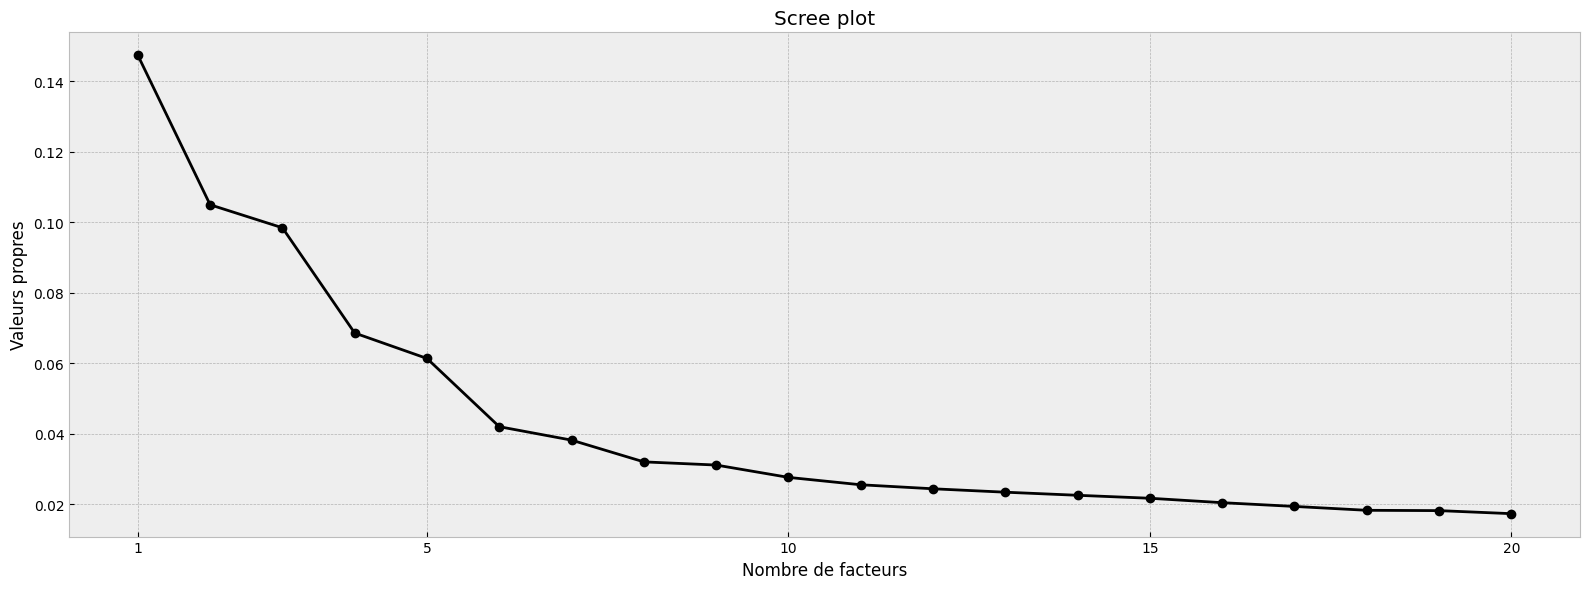

In [99]:
# Passage des données standardisées au format np.ndarray
Y = estimation_sample_std.to_numpy()
# Nombre d'observations et de variables 
T, N = Y.shape
# Calcul des r = 20 premières valeurs propres de la matrice de covariance de Y par PC
_, _, eigvals = pc(Y, r=20)

# Scree plot des valeurs propres de la matrice de covariance de Y
plt.figure(figsize=(16, 6))
plt.plot(np.arange(1, 21, 1), eigvals / 100, marker='o', color='black')

plt.xlabel('Nombre de facteurs'), plt.ylabel('Valeurs propres')
plt.title('Scree plot')
plt.xticks(ticks=[1, 5, 10, 15, 20])

plt.tight_layout()
plt.show()

Autocorrélogramme de l'unique facteur extrait par PC

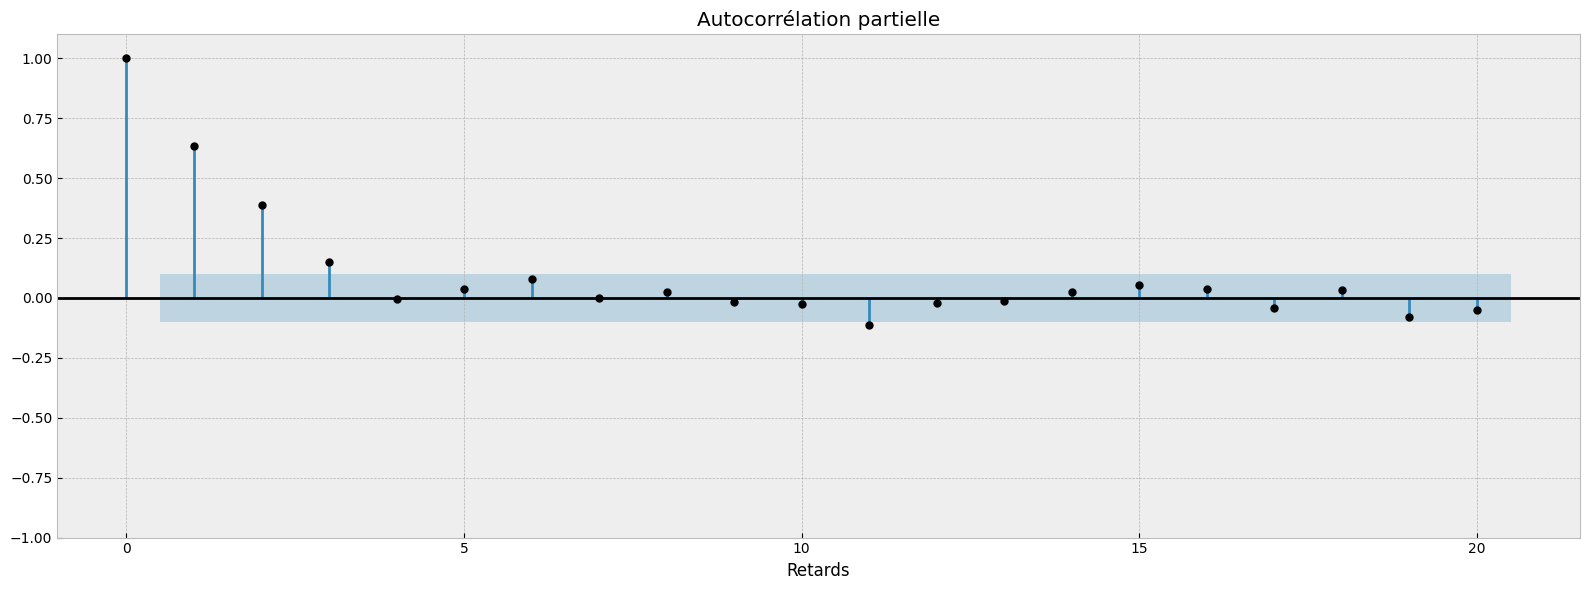

In [100]:
# Extraction d'un unique facteur par PC
pc_factor, _, _ = pc(Y, r=1)

# PACF de l'unique facteur extrait par PC
fig, ax = plt.subplots(figsize=(16, 6))
plot_pacf(x=pc_factor, ax=ax, lags=20, color='black')

plt.xlabel('Retards') 
plt.title('Autocorrélation partielle')
plt.ylim([-1, 1.1])

plt.tight_layout()
plt.show()

Extraction des facteurs par PC.

In [101]:
# Nombres de facteurs latents à extraire
n_factors = [1, 3, 7]
# Dictionnaire contenant les résultats de l'extraction par PC
pc_results = {}
# Extraction des facteurs par PC pour r = 1, 3, 7
for r in n_factors:
    # Application de la PC
    pc_factors, pc_loadings, _ = pc(Y, r)
    # Sauvegarde des résultats 
    pc_results[r] = {
        'Factors': pc_factors,
        'Loadings': pc_loadings
    }

Extraction des facteurs par Two Step Least Squares.

In [ ]:
# Dictionnaire contenant les résultats de l'extraction par TS-LS
tsls_results = {}
# Extraction des facteurs par Two Step Least Squares pour r = 1, 3, 7
for r in n_factors:
    # Application de l'algorithme TS-LS
    tsls_factors, tsls_loadings, tsls_phi, tsls_diag_sigma_e = tsls(Y, r)
    # Sauvegarde des résultats
    tsls_results[r] = {
        'Factors': tsls_factors,
        'Loadings': tsls_loadings,
        'Phi': tsls_phi,
        'Diag Sigma E': tsls_diag_sigma_e
    }

Extraction des facteurs par l'algorithme d'Espérance-Maximisation.

L'extraction de facteurs latents via l'algorithme ML-EM entraine des OverFlowError lorsque $r > 1$.  
Par conséquence, nous considérons divers niveaux de tolérance permettant une exécution sans interruption.

In [ ]:
# Niveaux de tolérance à considérer pour r = 1, 3, 7
tols = [1e-4, 10, 100]
# Dictionnaire contenant les résultats de l'extraction par ML-EM
mlem_results = {}
# Extraction des facteurs par algorithme d'Espérance Maximisation pour r = 1, 3, 7
for r, tol in zip(n_factors, tols):
    # Application de l'algorithme ML-EM
    mlem_factors, mlem_loadings, mlem_phi, mlem_diag_sigma_e, mlem_loglik = mlem(Y, r, tol, max_iter=100)
    # Sauvegarde des résultats
    mlem_results[r] = {
        'Factors': mlem_factors,
        'Loadings': mlem_loadings,
        'Phi': mlem_phi,
        'Diag Sigma E': mlem_diag_sigma_e,
        'Log-Lik': mlem_loglik
    }

Bar Plot des charges factorielles estimées

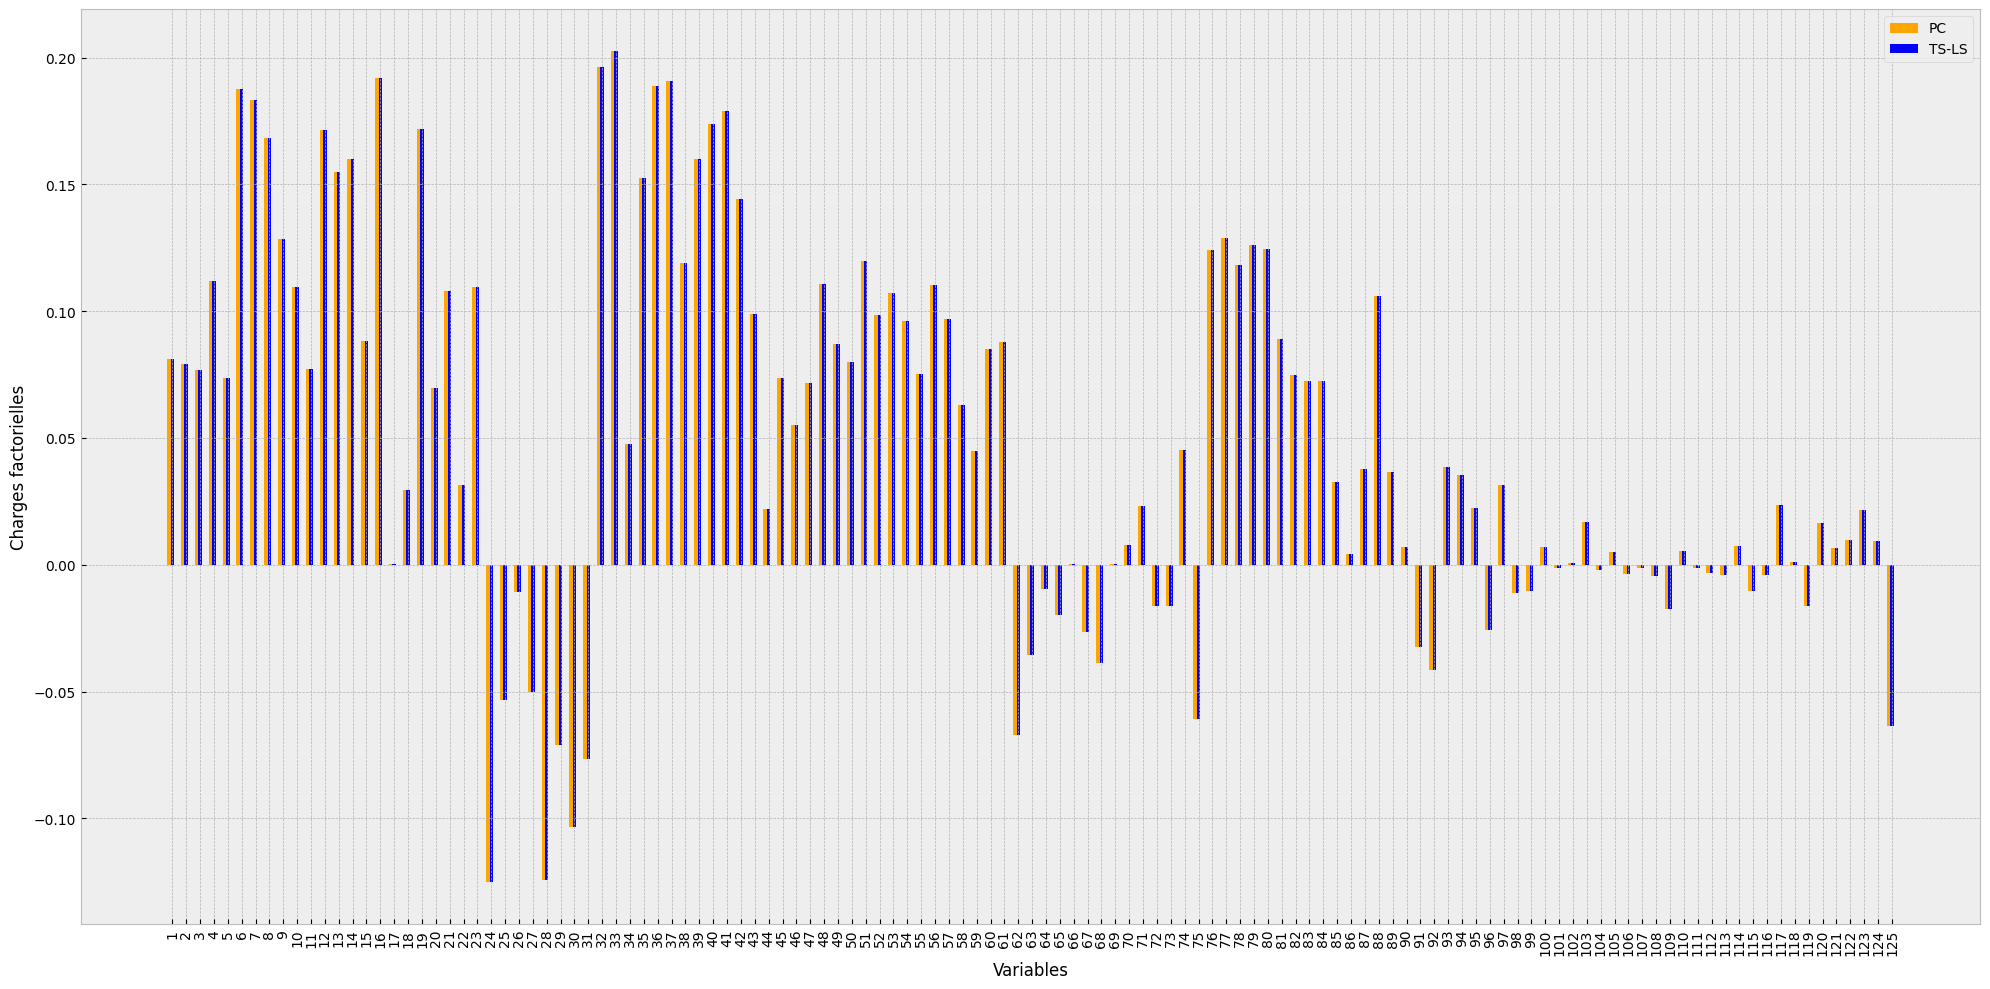

In [103]:
# Nombre de facteurs à considérer
r = 1
# Epaisseur des barres
bar_width = 0.25
# Axe des abscisses pour les charges extraites par PC
x_pc = np.arange(1, N+1, 1)
# Axe des abscisses pour les charges extraites par TS-LS
x_tsls = [x + bar_width for x in x_pc]
# Axe des abscisses pour les charges extraites par ML-EM
x_mlem = [x + bar_width for x in x_tsls]

# Représentation graphique des charges factorielles extraites par les diverses méthodes pour r = 1
fig, ax = plt.subplots(figsize=(20, 10))
ax.bar(x_pc, pc_results[r]['Loadings'].flatten(), color='orange', width=bar_width, label='PC')
ax.bar(x_tsls, tsls_results[r]['Loadings'].flatten(), color='blue', width=bar_width, label='TS-LS')
ax.bar(x_mlem, mlem_results[r]['Loadings'].flatten(), color='green', width=bar_width, label='ML-EM')

ax.set_xlabel('Variables'), ax.set_ylabel('Charges factorielles')
ax.set_xticks([x + bar_width for x in range(1, N+1)])
ax.set_xticklabels(x_pc, rotation=90)

plt.legend()
plt.tight_layout()
plt.show()

Plot du facteur estimé

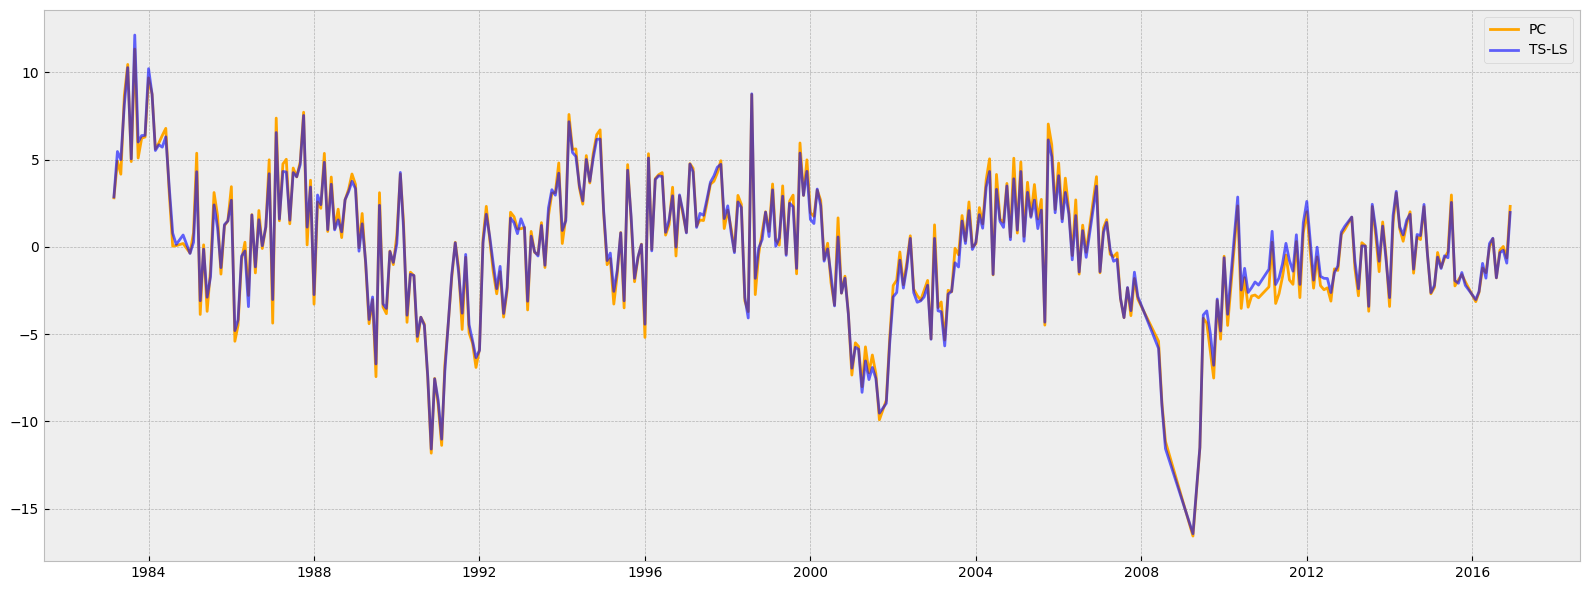

In [104]:
# Représentation graphique du facteur extrait par les diverses méthodes
plt.figure(figsize=(16, 6))

plt.plot(dates, pc_results[r]['Factors'], color='orange', label='PC')
plt.plot(dates, tsls_results[r]['Factors'], color='blue', alpha=.6, label='TS-LS')
plt.plot(dates, mlem_results[r]['Factors'], color='black', alpha=.6, label='ML-EM')

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Index secondaire du DataFrame de résultats
secondary = ['Σ σ_i^2', 'φ11', 'Log-Lik']
# Création d'une liste de tuples pour multi-indices
index = []
for r in n_factors:
    for sec in secondary:
        index.append((r, sec))
# Création du multi-indice à partir des tuples obtenus
multi_index = pd.MultiIndex.from_tuples(index, names=['r', ''])
# Création du dictionnaire de résultats
results = {
    'TS-LS': [
        np.sum(tsls_results[r]['Diag Sigma E']) if metric == 'Σ σ_i^2'
        else tsls_results[r]['Phi'][0][0] if metric == 'φ11'
        else None
        for r in n_factors for metric in secondary
    ],
    'ML-EM': [
        np.sum(mlem_results[r]['Diag Sigma E']) if metric == 'Σ σ_i^2'
        else mlem_results[r]['Phi'][0][0] if metric == 'φ11'
        else mlem_results[r]['Log-Lik']
        for r in n_factors for metric in secondary
    ]
}
# Affichage des résultats
pd.DataFrame(data=results, index=multi_index).round(decimals=3)

In [124]:
# Sélection de la série INDPRO stationnarisée au format ndarray
Yi = estimation_sample['INDPRO'].to_numpy()
# Nombre de retards pour Yi et F
q, s = 4, 4
# Dictionnaire contenant les résultats globaux de régression
ols_results = {}
# Résultats de régression non augmentée des facteurs latents Ar(q)
coefs, _, sigma_eps, R2_adj = augmented_ols(Yi, q, F=None, s=0)
# Ajout aux résultats globaux
ols_results['AR'] = {
        'µ': coefs[0].item(),
        'δ1': coefs[1].item(),'δ2': coefs[2].item(), 'δ3': coefs[3].item(), 'δ4': coefs[4].item(),
        'σu': sigma_eps,
        'R2': R2_adj
}
# Dictionnaire contenant les résultats de régression pour facteurs extraits par PC
pc_ols = {}
# Application de la régression augmentée pour r = 1, 3, 7
for r in n_factors:
    coefs, _, sigma_eps, R2_adj = augmented_ols(Yi=Yi, q=q, F=pc_results[r]['Factors'], s=s)
    # Sauvegarde des résultats
    pc_ols[r] = {
        'µ': coefs[0].item(),
        'δ1': coefs[1].item(),'δ2': coefs[2].item(), 'δ3': coefs[3].item(), 'δ4': coefs[4].item(),
        'β11': coefs[5].item(), 'β12': coefs[6].item(),'β13': coefs[7].item(), 'β14': coefs[8].item(), 
        'σu': sigma_eps,
        'R2': R2_adj
    }
# Ajout aux résultats globaux
ols_results['PC'] = pc_ols
# Dictionnaire contenant les résultats de régression pour facteurs extraits par TS-LS
tsls_ols = {}
# Application de la régression augmentée pour r = 1, 3, 7
for r in n_factors:
    coefs, _, sigma_eps, R2_adj = augmented_ols(Yi=Yi, q=q, F=tsls_results[r]['Factors'], s=s)
    # Sauvegarde des résultats
    tsls_ols[r] = {
        'µ': coefs[0].item(),
        'δ1': coefs[1].item(),'δ2': coefs[2].item(), 'δ3': coefs[3].item(), 'δ4': coefs[4].item(),
        'β11': coefs[5].item(), 'β12': coefs[6].item(),'β13': coefs[7].item(), 'β14': coefs[8].item(), 
        'σu': sigma_eps,
        'R2': R2_adj
    }
# Ajout aux résultats globaux
ols_results['TS-LS'] = tsls_ols
# Dictionnaire contenant les résultats de régression pour facteurs extraits par ML-EM
mlem_ols = {}
# Application de la régression augmentée pour r = 1, 3, 7
for r in n_factors:
    coefs, _, sigma_eps, R2_adj = augmented_ols(Yi=Yi, q=q, F=mlem_results[r]['Factors'], s=s)
    # Sauvegarde des résultats
    mlem_ols[r] = {
        'µ': coefs[0].item(),
        'δ1': coefs[1].item(),'δ2': coefs[2].item(), 'δ3': coefs[3].item(), 'δ4': coefs[4].item(),
        'β11': coefs[5].item(), 'β12': coefs[6].item(),'β13': coefs[7].item(), 'β14': coefs[8].item(), 
        'σu': sigma_eps,
        'R2': R2_adj
    }
# Ajout aux résultats globaux
ols_results['ML-EM'] = mlem_ols